#  Aztec Summary Report
## Initial Investigation of Censorship Impact

**Date:** May 2, 2024

## Overview of Work

This is an v1 report, prepared in response to the request for information regarding the impact of L1 censorship on the design parameters of the block production phase durations. 

To answer this question, we have focused on a simplified version of our current modeling efforts. Although we make the trade-off of detail for clarity, the assumptions are based in analysis of an extensive data set of actual blocks from the Ethereum blockchain. 

## Model Assumptions

Any model must make simplifying assumptions. The model in use for the current analysis makes the following assumptions in its logic and execution:

* Agents are always *willing* to act. They make no economic considerations with regards to cost or profit. 
    * As time spent in a particular phase progresses, the probability that an agent will take the indicated action increases towards 1.0.
* If the process enters Race Mode, a valid block may still be produced through it.  
* There are no censoring validators.
* Censoring Builders are pre-set from information of current censorship assumptions. Specifically, we construct a set of "censoring builders", and fill it with builders indicated as severely censoring by censorship.pics 
* Events, such as a builder censoring, are independent (as opposed to them censoring strategically, by then bidding higher on the following slot)

This last assumption in particular deserves further exploration, particularly in light of preliminary data analysis below. 


## Simulation Parameters

* `N_timesteps`: how many iterations the model should take
* `N_samples:` how many Monte Carlo runs 


The simulation sweeps over all possible combinations of parameter values, as indicated in the following table.

| Parameter Name  | Values Swept    |
|--------------------------------------|-----------------|
| `phase_duration_proposal_min_blocks` | [0, 3] |
| `phase_duration_proposal_max_blocks` | [3, 12]|
| `phase_duration_reveal_min_blocks`   | [0,3]  |
| `phase_duration_reveal_min_blocks`   | [3, 24]|
| `phase_duration_reveal_max_blocks`   | [0, 3] |
| `phase_duration_commit_bond_min_blocks` | [0,3] |
| `phase_duration_commit_bond_max_blocks` | [3,24] |
| `phase_duration_rollup_min_blocks`      | [0, 15] |
| `phase_duration_rollup_max_blocks`      | [15, 80] |
----------------------------------------------------------

# Censorship Empirical Data

Courtesy of Toni, we use his dataset on builders, validators and mevboost to construct a censorship series.
Specifically, we have been provided with an updated dataset going from the Merge until April 25th.
To increase relevance, we further dropped all blocks before the Dencun hardfork.

With this set, we can construct a timeseries. This timeseries is initially constructed with 'False' for each timestep. By picking a starting block_number from the dataset, we can then set values to 'True' whenever a priorly indicated censoring builder has a slot. This gives as a snapshot of the empirical data, which lets us evaluate quickly whether a simulation timestep is 'censored', disallowing any agent (except for the current L1 builder) to make an L1 transaction. 

Picking a starting block_number is a bit of an art itself - as an example, we could have picked different start times for every simulation run. This would have let us run over every possible series. However, this would make the results less robust, as we would compare different paramater values over different environments. 

Instead, we choose to test a starting time for every parameter value. This leaves results more robust. 
We do this by including starting times as a sweep parameter, building cartesian products with them.
To pick starting times, we go with a hybrid approach.
On one hand, the goal of this analysis is to start from stringend censorship assumptions - quasi worst case. 
To emulate that, we are hand-picking some of the start times by choosing time series that include long consecutive runs of slots in a row by the same, main censoring builder: Beaverbuild

While handpicking makes up about 20% of our starting times, we Sobol Sample the remaining ones. 

Future iterations might relax the set of censoring builders, or test incomplete censoring (such as increasing gas price), or introduce strategic censoring. Similarly, we might test different time series (such as before Dencun), sample all series randomly, etc. 

## KPIs

A KPI helps us assess whether simulation trajectories score better or worse on our goals. As trajectories vary in the underlying parameters (such as different phase durations, or block rewards) we can use them to identify parameter combinations that score better on our overall goals. These can be seen in `metrics.py`

- `proportion_race_mode`: This measures the proportion of race_mode to total blocks.
- `proportion_skipped` : This measures the proportion of blocks that were skipped (no proposals, or no finalized proof).
- `average_duration_finalized_blocks`: This measures the average duration of succesfully finalized blocks.
- `stddev_duration_finalized_blocks`: This measures the standard deviation of the duration of succesfully finalized blocks.


## Code and Data Imports 

In [1]:
import seaborn as sns
import plotly.io as pio
import matplotlib.pyplot as plt
import plotly.express as px
import os
import pandas as pd
import sys
sys.path.append('../')

from IPython.core.getipython import get_ipython

pio.renderers.default = "png"

## Brief Data Exploration

Restricting the data set to only slots since the Dencun event, it is possible to observe the proportion of blocks for each builder. 

Key Insights:
* The largest builder is `beaverbuild.org`
* The full list of censoring builders accounts for 60% of blocks built since Dencun, both over the entire time range and the last 1000 blocks. 
* The time series of censoring builders shows autocorrelation, which deserves further study and may suggest modifying our assumptions of independence. 

In [2]:
local_path = '../data/auxiliary/eth_builder_validator_data.parquet.gz'
if os.path.isfile(local_path):
    data = pd.read_parquet(
        local_path).query(f"slot > 8626718")
else:
    data = pd.read_parquet(
        's3://aztec-gddt/aux-data/eth_builder_validator_data.parquet.gz').query(f"slot > 8626718")

In [3]:
DENCUN_SLOT = 8626718
data_to_use = data.query(f"slot > {DENCUN_SLOT}")

In [4]:
CENSORING_BUILDERS = ['beaverbuild.org',
                      'rsync-builder.xyz', 
                      'Flashbots', 
                      'BuildAI (https://buildai.net)', 
                      'Gambit Labs',
                      'boba-builder.com',
                      'Builder + www.btcs.com',
                      'builder0x69',
                      '0x83bee517',
                      'BloXroute',
                      'I can haz block',
                      'EigenPhi',
                      'Edennetwork',
                      'blockbeelder'
                     ]

data_to_use.loc[:, 'is_builder_censor'] = data_to_use['builder'].apply(lambda x: int(x in CENSORING_BUILDERS))

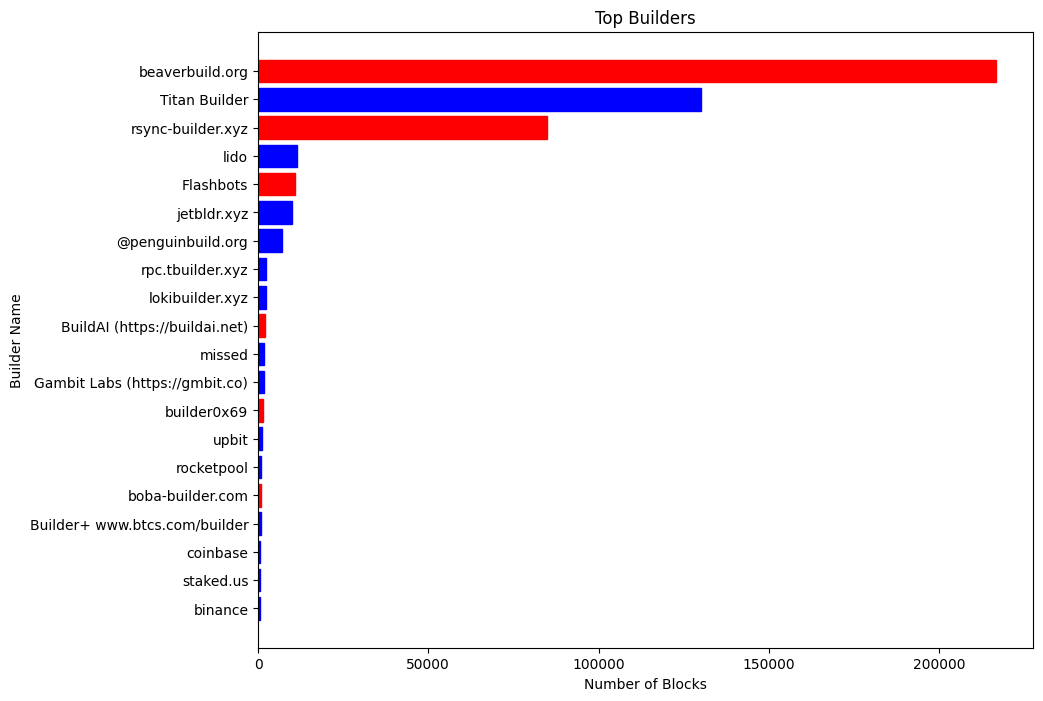

In [5]:
# Plot for top builders

# Number of top entries you want to display
NUM_TOP_ENTRIES = 20

# Character length of name, for readability
MAX_CHAR_LEN = 30

# Calculating the count of each unique value
counts = data_to_use['builder'].value_counts()

# Selecting the top N entries
top_n = counts.nlargest(NUM_TOP_ENTRIES)

# Creating a horizontal bar plot
plt.figure(figsize=(10, 8))
bars = plt.barh(top_n.index, top_n.values)

# Color bars based on whether the builder is in the censoring list
for bar, builder in zip(bars, top_n.index):
    if builder in CENSORING_BUILDERS:
        bar.set_color('red')  # Color for censoring builders
    else:
        bar.set_color('blue')  # Color for non-censoring builders


labels = [label[:MAX_CHAR_LEN] + '...'
         if len(label) > MAX_CHAR_LEN 
         else label 
         for label in top_n.index]

plt.xlabel('Number of Blocks')
plt.ylabel('Builder Name')
plt.yticks(ticks = range(NUM_TOP_ENTRIES), labels=labels)
plt.title('Top Builders')
plt.gca().invert_yaxis()  # To display the largest at the top
plt.show()

# Some tests to make sure we use the right data

In [6]:
# Determining total proportion from list
data_to_use['is_builder_censor'].mean()

0.6267825558257794

In [7]:
data_to_use['is_builder_censor'].head(-1_000).mean()

0.627078817032454

In [8]:
data_to_use['is_builder_censor'].autocorr(lag = 1)

0.4151694798775151

In [9]:
data_to_use['is_builder_censor'].head(-1_000).autocorr(lag = 1)

0.41474619144794644

## Analysis of Simulation Results

In [10]:
# CURRENT FILE IS A MOCK. NEEDS TO BE CHANGED TO ACTUAL DATA.
timestamp = '2024-05-02T225037Z'
FILENAME = f"s3://aztec-gddt/psuu_run_{timestamp}/trajectory_tensor.csv.zip"
sim_df = pd.read_csv(FILENAME, compression='zip')

In [11]:
sim_df.columns

Index(['Unnamed: 0', 'index', 'simulation', 'subset', 'run',
       'phase_duration_proposal_min_blocks',
       'phase_duration_proposal_max_blocks',
       'phase_duration_reveal_min_blocks', 'phase_duration_reveal_max_blocks',
       'phase_duration_commit_bond_min_blocks',
       'phase_duration_commit_bond_max_blocks',
       'phase_duration_rollup_min_blocks', 'phase_duration_rollup_max_blocks',
       'phase_duration_race_min_blocks', 'phase_duration_race_max_blocks',
       'daily_block_reward', 'proportion_race_mode',
       'proportion_slashed_prover', 'proportion_slashed_sequencer',
       'proportion_skipped', 'average_duration_finalized_blocks',
       'stddev_duration_finalized_blocks',
       'average_duration_nonfinalized_blocks',
       'stddev_duration_nonfinalized_blocks', 'delta_total_revenue_agents'],
      dtype='object')

In [12]:
PHASES = ["proposal", "reveal", "commit_bond", "rollup", "race"]
for phase in PHASES:
    min_col = f'phase_duration_{phase}_min_blocks'
    max_col = f'phase_duration_{phase}_max_blocks'
    sim_df[f'{phase}_is_fixed'] = (sim_df[min_col] == sim_df[max_col])

In [13]:
# Drop less relevant columns

sim_df.drop(columns = ['run', 'subset', 'simulation',
       'daily_block_reward',  'proportion_slashed_prover',
       'proportion_slashed_sequencer', 
       'average_duration_finalized_blocks', 'average_duration_nonfinalized_blocks',
       'stddev_duration_finalized_blocks', 'stddev_duration_nonfinalized_blocks',
       'delta_total_revenue_agents'], inplace = True)

## Mutual Information

[Mutual Information](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_f_test_vs_mi.html#sphx-glr-auto-examples-feature-selection-plot-f-test-vs-mi-py) can be thought of as a generalization of the correlation coefficient or F-test, tracking the strength of relationships that aren't necessarily linear. 

In the code below, we
* calculate the mutual information between each potential parameter and the KPI.
* drop any parameters which have negligible mutual information with KPI.
* plot a heatmap of the remaining relationship.

This gives insight into which variables are most impactful on the KPIs. 

In [14]:
from sklearn.feature_selection import mutual_info_regression

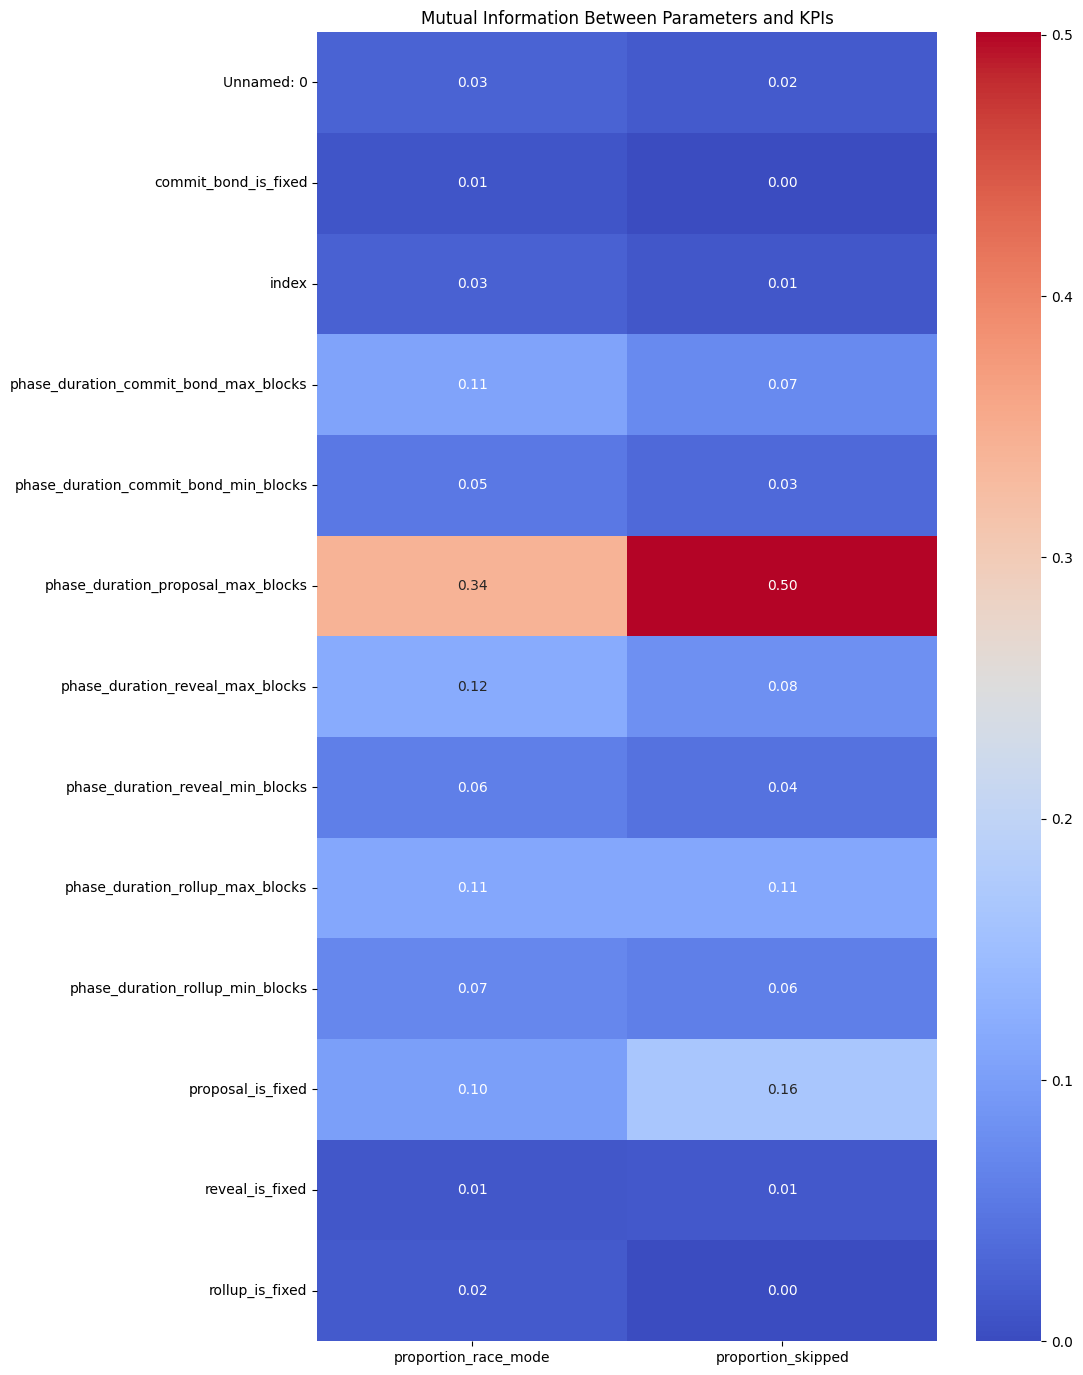

In [15]:
kpis = ['proportion_race_mode', 
        'proportion_skipped']

    
features = sim_df.columns.difference(kpis)  # All columns except kpis

# Calculate mutual information for each target and store in a DataFrame
mi_results = pd.DataFrame(index=features)

for kpi in kpis:
    mi_scores = mutual_info_regression(sim_df[features], sim_df[kpi])
    mi_results[kpi] = mi_scores


all_zero_rows = (mi_results < 0.01).all(axis = 1)
mi_results = mi_results[~all_zero_rows]

# Plotting
plt.figure(figsize=(10, len(features)))  # Adjust size as needed
sns.heatmap(mi_results, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mutual Information Between Parameters and KPIs')
plt.show()